# LibMultiLabel Fine-tuning Experiment on EUR-Lex

This notebook demonstrates how to fine-tune a BERT-based model using LibMultiLabel on the EUR-Lex dataset.  
We compare three optimizer variants:
1. PyTorch AdamW (`torch_adamw`)
2. Hugging Face AdamW with bias correction enabled (`hf_adamw`, correct_bias=True)
3. Hugging Face AdamW with bias correction disabled (`hf_adamw`, correct_bias=False)

The notebook downloads and converts the raw EUR-Lex files, loads configuration from YAML, prepares data loaders,  
defines a custom model that records epoch-level training loss and validation metrics, runs the experiments, and then plots  
the training loss, validation Micro‑F1, and validation RP@5 versus epochs.


###  Import Required Libraries

In [1]:
import yaml
import os
import matplotlib.pyplot as plt
import numpy as np
# Hugging Face AdamW optimizer
from transformers import AdamW as HFAdamW
from transformers import AutoTokenizer
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
from torch.utils.data import RandomSampler

from abc import abstractmethod
from datetime import datetime
import lightning as L
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

from libmultilabel.common_utils import argsort_top_k, dump_log
from libmultilabel.nn.metrics import get_metrics, tabulate_metrics


from libmultilabel.nn.model import Model as BertForMultiLabel
from transformers import BertModel
import numpy as np
np.Inf = np.inf

# LibMultiLabel modules
import libmultilabel
from libmultilabel.common_utils import AttributeDict, is_multiclass_dataset
from libmultilabel.nn.networks.bert import BERT
from libmultilabel.nn.data_utils import load_datasets, load_or_build_label, get_dataset_loader
from libmultilabel.common_utils import timer
from libmultilabel.nn.attentionxml import PLTTrainer
from libmultilabel.nn import data_utils, networks
from libmultilabel.nn.model import Model, MultiLabelModel
from libmultilabel.nn.nn_utils import init_device, init_model, init_trainer, set_seed
# from libmultilabel.nn.attentionxml import Trainer

#from torch_trainer import TorchTrainer as Trainer


from torch_trainer.trainer import Trainer as Trainer

/home/tmp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tmp/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/tmp/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext;

### Download and Convert the Dataset

In [2]:
import gdown

# Convert share links to direct download URLs:
train_url = "https://drive.google.com/uc?id=19YPcHOEXCHtR882vgdMIglx-SsIaL7CD"
train_eur = "eurlex_train.txt"
gdown.download(train_url, train_eur, quiet=False)

test_url = "https://drive.google.com/uc?id=1QdTWYk7s6n_5BUZ7Fjy2h_5O6XvWjXDM"
test_eur = "eurlex_test.txt"
gdown.download(test_url, test_eur, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=19YPcHOEXCHtR882vgdMIglx-SsIaL7CD
From (redirected): https://drive.google.com/uc?id=19YPcHOEXCHtR882vgdMIglx-SsIaL7CD&confirm=t&uuid=49089274-69f6-42ab-8f40-54c6ecb92ebc
To: /home/tmp/eurlex_train.txt
100%|██████████| 132M/132M [00:02<00:00, 64.8MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1QdTWYk7s6n_5BUZ7Fjy2h_5O6XvWjXDM
To: /home/tmp/eurlex_test.txt
100%|██████████| 32.5M/32.5M [00:00<00:00, 82.3MB/s]


'eurlex_test.txt'

### Load Configuration, Set Seed, and Prepare Data Loaders 

In [3]:
def convert_to_utf8(file_path):
    # Use engine='python' and skip bad lines
    df = pd.read_csv(
        file_path,
        sep="\t",
        header=None,
        encoding="latin1",
        engine="python",       # use the Python engine instead of the C engine
        on_bad_lines="skip",   # skip lines that cause parsing issues
        quoting=csv.QUOTE_NONE
    )
    new_file_path = file_path.replace(".txt", "_utf8.txt")
    df.to_csv(new_file_path, sep="\t", index=False, header=False, encoding="utf-8")
    return new_file_path


    # Convert training and test files to UTF-8.
import pandas as pd
import csv
train_eur = convert_to_utf8(train_eur)
test_eur = convert_to_utf8(test_eur)

print("Converted training_file:", train_eur)
print("Converted test_file:", test_eur)


Converted training_file: eurlex_train_utf8.txt
Converted test_file: eurlex_test_utf8.txt


In [4]:
# Step 1: Fix the random seed
import random
import numpy as np
##################################################


# Step 3: Load the YAML config we created

with open("config_bert_eurlex.yaml", "r") as f:
    config = yaml.safe_load(f)

set_seed(config["seed"])
device = init_device()  # auto-detects GPU if available

Global seed set to 1337


### Define Custom Model and Experiment Function

In [5]:
# load_datasets: assumes the raw text files are in "labels<TAB>text" format.
datasets = load_datasets(training_data='eurlex_train_utf8.txt',
                         test_data='eurlex_test_utf8.txt',
                         tokenize_text=False)
classes = load_or_build_label(datasets)

# Initialize the tokenizer (here we use the LM weight from the config)
tokenizer = AutoTokenizer.from_pretrained(config["network_config"]["lm_weight"])


In [6]:
# Create data loaders for train, validation and test splits.
# (If no validation file is provided, LibMultiLabel splits train into 80/20.)
loaders = {}
for split in ["train", "val", "test"]:
    loaders[split] = get_dataset_loader(
        data = datasets[split],
        classes = classes,
        device = device,
        max_seq_length = config["max_seq_length"],
        batch_size = config["batch_size"],
        shuffle = True if split == "train" else False,
        tokenizer = tokenizer
    )

In [7]:
def run_experiment_with_optimizer(optimizer_type="torch_adamw", hf_correct_bias=True, exp_name=""):
    """
    Runs a fine-tuning experiment on EUR-Lex using a chosen optimizer.
    optimizer_type: "torch_adamw" for PyTorch's AdamW;
                    "hf_adamw" for Hugging Face AdamW.
    hf_correct_bias: For hf_adamw, whether to enable bias correction.
    exp_name: A name for the run (used for checkpointing/logging).
    """
    # Create a copy of the configuration and modify checkpoint_dir based on the experiment name.
    config_exp = config.copy()
    config_exp["checkpoint_dir"] = os.path.join("runs", exp_name)
    
    # Initialize the trainer from LibMultiLabel.
    trainer = init_trainer(checkpoint_dir=config_exp["checkpoint_dir"],
                           epochs=config_exp["epochs"],
                           patience=config_exp["patience"],
                           val_metric=config_exp["val_metric"])
    
    # Initialize the network. Here we call the model constructor by name (e.g. "BERT")
    network = getattr(networks, config_exp["model_name"])(
        embed_vecs=None,
        num_classes=len(classes),
        **config_exp["network_config"]
    )
    
    # Create a custom model instance.
    model = CustomModel(
        classes=classes,
        network=network,
        multiclass=False,
        **config_exp
    )
    
    # Setup the optimizer.
    if optimizer_type == "torch_adamw":
        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=config_exp["learning_rate"],
                                      weight_decay=config_exp["weight_decay"])
    elif optimizer_type == "hf_adamw":
        optimizer = HFAdamW(model.parameters(),
                            lr=config_exp["learning_rate"],
                            weight_decay=config_exp["weight_decay"],
                            correct_bias=hf_correct_bias)
    else:
        raise ValueError("Invalid optimizer type")
    
    # Overwrite the trainer's optimizer.
    trainer.optimizer = optimizer
    trainer.optimizer_name = (f"{optimizer_type}_correct_bias={hf_correct_bias}"
                                if optimizer_type=="hf_adamw" else optimizer_type)
    
    # Run training. Note: trainer.fit records training losses and validation metrics.
    trainer.fit(model, loaders["train"], loaders["val"])
    
    # Return the trainer (which holds loss and metric history) and the trained model.
    return trainer, model

In [8]:
class CustomModel(MultiLabelModel):
    def __init__(self, classes, network, loss_function="binary_cross_entropy_with_logits", **kwargs):
        super().__init__(num_classes=len(classes), **kwargs)
        self.network = network
        # Set loss_function (using torch.nn.functional)
        import torch.nn.functional as F
        # You could also call a helper function like self.configure_loss_function(loss_function)
        # For simplicity:
        self.loss_function = getattr(F, loss_function)
        
        # Initialize attributes to record training loss
        self.train_losses_per_epoch = []
        self._epoch_loss_sum = 0.0
        self._epoch_sample_count = 0

    def shared_step(self, batch):
        target_labels = batch["label"]
        pred_logits = self(batch)
        loss = self.loss_function(pred_logits, target_labels.float())
        return loss, pred_logits

    def training_step(self, batch, batch_idx):
        loss, _ = self.shared_step(batch)
        batch_size = batch["label"].size(0)
        self._epoch_loss_sum += loss.item() * batch_size
        self._epoch_sample_count += batch_size
        return loss

    def on_train_epoch_end(self):
        if self._epoch_sample_count > 0:
            avg_loss = self._epoch_loss_sum / self._epoch_sample_count
        else:
            avg_loss = 0.0
        self.train_losses_per_epoch.append(avg_loss)
        self._epoch_loss_sum = 0.0
        self._epoch_sample_count = 0

    def on_validation_epoch_end(self):
        metrics = self._shared_eval_epoch_end(split="val")
        if not hasattr(self, "valid_metric_scores"):
            self.valid_metric_scores = []
        self.valid_metric_scores.append(metrics)
        return metrics


### Run Experiments for Different Optimizers

In [9]:
config["epochs"] = 100
config["batch_size"] = 32
config["learning_rate"] = 0.00005
config["patience"] =15
config["momentum"] = 0
config["eval_batch_size"] =32


### Experiment 1: Using PyTorch AdamW optimizer.

In [ ]:
# Experiment 1: Using PyTorch AdamW optimizer.
exp_name_torch = "eurlex_torch_adamw"
print(f"\n--- Running experiment: {exp_name_torch} ---")

trainer_torch, model_torch = run_experiment_with_optimizer(
    optimizer_type="torch_adamw",
    hf_correct_bias=None,  # Not applicable for torch_adamw.
    exp_name=exp_name_torch
)

results_torch = {
    "train_losses": model_torch.train_losses_per_epoch,
    "val_metrics": model_torch.valid_metric_scores
}



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..



--- Running experiment: eurlex_torch_adamw ---


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/tmp/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory runs/eurlex_torch_adamw exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | eval_metric | MetricCollection | 0     
1 | network     | BERT             | 112 M 
-------------------------------------------------
112 M     Trainable params
0         Non-trainable params
112 M     Total params
449.621   Total estim

Epoch 0:   0%|          | 3/1537 [00:00<04:08,  6.18it/s]

/home/tmp/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:468.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: 100%|██████████| 1537/1537 [02:16<00:00, 11.23it/s]

/home/tmp/.local/lib/python3.10/site-packages/libmultilabel/nn/metrics.py:176: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  cum_discount = discount.cumsum(dim=0)


Epoch 28: 100%|██████████| 1537/1537 [02:35<00:00,  9.87it/s]

Training Losses per Epoch for Experiment 1 (torch_adamw):
  Epoch 1: 0.0320
  Epoch 2: 0.0091
  Epoch 3: 0.0090
  Epoch 4: 0.0090
  Epoch 5: 0.0090
  Epoch 6: 0.0089
  Epoch 7: 0.0089
  Epoch 8: 0.0088
  Epoch 9: 0.0087
  Epoch 10: 0.0087
  Epoch 11: 0.0087
  Epoch 12: 0.0087
  Epoch 13: 0.0087
  Epoch 14: 0.0087
  Epoch 15: 0.0095
  Epoch 16: 0.0090
  Epoch 17: 0.0090
  Epoch 18: 0.0090
  Epoch 19: 0.0090
  Epoch 20: 0.0090
  Epoch 21: 0.0090
  Epoch 22: 0.0090
  Epoch 23: 0.0090
  Epoch 24: 0.0090
  Epoch 25: 0.0090
  Epoch 26: 0.0090
  Epoch 27: 0.0090
  Epoch 28: 0.0090
  Epoch 29: 0.0090

Validation Metrics per Epoch for Experiment 1 (torch_adamw):
  Epoch 1: {'Another-Macro-F1': 0.0, 'Macro-F1': 0.0, 'Micro-F1': 0.0, 'P@1': 0.043916720884840596, 'P@5': 0.05393624052686511, 'RP@5': 0.05615918521533636, 'nDCG@5': 0.05397001971904535}
  Epoch 2: {'Another-Macro-F1': 0.0, 'Macro-F1': 0.0, 'Micro-F1': 0.0, 'P@1': 0.0689655

### Experiment 2: Using Hugging Face AdamW with bias correction enabled.

In [ ]:
# Experiment 2: Using Hugging Face AdamW with bias correction enabled.
exp_name_hf_true = "eurlex_hf_adamw_bias_True"
print(f"\n--- Running experiment: {exp_name_hf_true} ---")

trainer_hf_true, model_hf_true = run_experiment_with_optimizer(
    optimizer_type="hf_adamw",
    hf_correct_bias=True,
    exp_name=exp_name_hf_true
)

results_hf_true = {
    "train_losses": model_hf_true.train_losses_per_epoch,
    "val_metrics": model_hf_true.valid_metric_scores
}



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..



--- Running experiment: eurlex_hf_adamw_bias_True ---


/home/tmp/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory runs/eurlex_hf_adamw_bias_True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | eval_metric | MetricCollection | 0     
1 | network     | BERT             | 112 M 
-------------------------------------------------
112 M     Trainable params
0         Non-trainable params
112 M     Total params
449.621   Total estimated model params size (MB)


Epoch 97: 100%|██████████| 1537/1537 [02:34<00:00,  9.95it/s]

Training Losses per Epoch for Experiment 2 (hf_adamw_bias_True):
  Epoch 1: 0.0319
  Epoch 2: 0.0091
  Epoch 3: 0.0090
  Epoch 4: 0.0090
  Epoch 5: 0.0099
  Epoch 6: 0.0090
  Epoch 7: 0.0088
  Epoch 8: 0.0086
  Epoch 9: 0.0083
  Epoch 10: 0.0089
  Epoch 11: 0.0080
  Epoch 12: 0.0078
  Epoch 13: 0.0076
  Epoch 14: 0.0073
  Epoch 15: 0.0070
  Epoch 16: 0.0067
  Epoch 17: 0.0065
  Epoch 18: 0.0063
  Epoch 19: 0.0060
  Epoch 20: 0.0059
  Epoch 21: 0.0057
  Epoch 22: 0.0055
  Epoch 23: 0.0053
  Epoch 24: 0.0051
  Epoch 25: 0.0050
  Epoch 26: 0.0048
  Epoch 27: 0.0047
  Epoch 28: 0.0045
  Epoch 29: 0.0044
  Epoch 30: 0.0043
  Epoch 31: 0.0041
  Epoch 32: 0.0040
  Epoch 33: 0.0039
  Epoch 34: 0.0038
  Epoch 35: 0.0036
  Epoch 36: 0.0035
  Epoch 37: 0.0034
  Epoch 38: 0.0033
  Epoch 39: 0.0032
  Epoch 40: 0.0031
  Epoch 41: 0.0030
  Epoch 42: 0.0029
  Epoch 43: 0.0028
  Epoch 44: 0.0027
  Epoch 45: 0.0026
  Epoch 46: 0.0025
  Epoch

### Experiment 3: Using Hugging Face AdamW with bias correction disabled.

In [ ]:
# Experiment 3: Using Hugging Face AdamW with bias correction disabled.
exp_name_hf_false = "eurlex_hf_adamw_bias_False"
print(f"\n--- Running experiment: {exp_name_hf_false} ---")

trainer_hf_false, model_hf_false = run_experiment_with_optimizer(
    optimizer_type="hf_adamw",
    hf_correct_bias=False,
    exp_name=exp_name_hf_false
)

results_hf_false = {
    "train_losses": model_hf_false.train_losses_per_epoch,
    "val_metrics": model_hf_false.valid_metric_scores
}



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..



--- Running experiment: eurlex_hf_adamw_bias_False ---


/home/tmp/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory runs/eurlex_hf_adamw_bias_False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | eval_metric | MetricCollection | 0     
1 | network     | BERT             | 112 M 
-------------------------------------------------
112 M     Trainable params
0         Non-trainable params
112 M     Total params
449.621   Total estimated model params size (MB)


Epoch 82: 100%|██████████| 1537/1537 [02:34<00:00,  9.94it/s]

Training Losses per Epoch for Experiment 3 (hf_adamw_bias_False):
  Epoch 1: 0.0316
  Epoch 2: 0.0091
  Epoch 3: 0.0090
  Epoch 4: 0.0090
  Epoch 5: 0.0100
  Epoch 6: 0.0090
  Epoch 7: 0.0088
  Epoch 8: 0.0086
  Epoch 9: 0.0083
  Epoch 10: 0.0080
  Epoch 11: 0.0077
  Epoch 12: 0.0073
  Epoch 13: 0.0069
  Epoch 14: 0.0064
  Epoch 15: 0.0061
  Epoch 16: 0.0058
  Epoch 17: 0.0055
  Epoch 18: 0.0052
  Epoch 19: 0.0049
  Epoch 20: 0.0047
  Epoch 21: 0.0044
  Epoch 22: 0.0042
  Epoch 23: 0.0040
  Epoch 24: 0.0038
  Epoch 25: 0.0036
  Epoch 26: 0.0034
  Epoch 27: 0.0032
  Epoch 28: 0.0031
  Epoch 29: 0.0029
  Epoch 30: 0.0027
  Epoch 31: 0.0026
  Epoch 32: 0.0024
  Epoch 33: 0.0023
  Epoch 34: 0.0021
  Epoch 35: 0.0020
  Epoch 36: 0.0019
  Epoch 37: 0.0018
  Epoch 38: 0.0017
  Epoch 39: 0.0016
  Epoch 40: 0.0015
  Epoch 41: 0.0014
  Epoch 42: 0.0013
  Epoch 43: 0.0012
  Epoch 44: 0.0011
  Epoch 45: 0.0010
  Epoch 46: 0.0010
  Epoc

### Plot Results for Each Experiment Separately

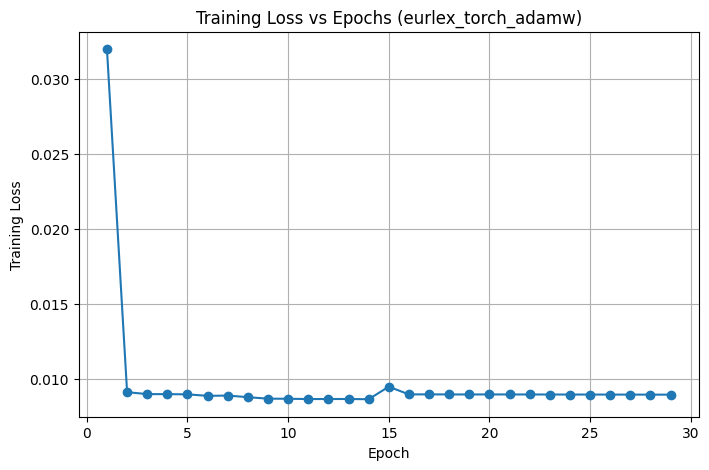

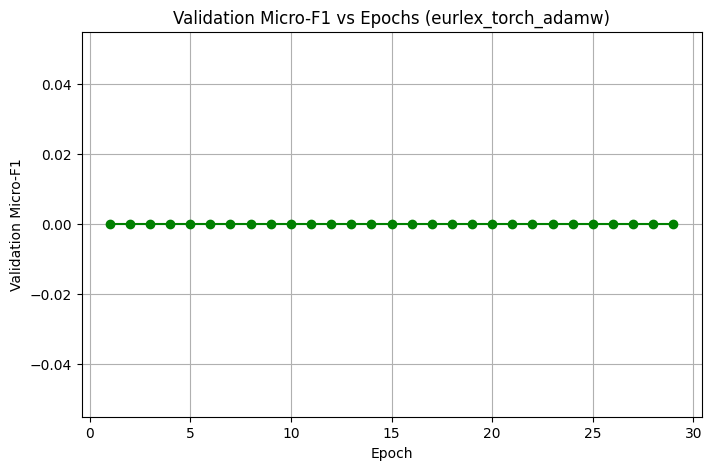

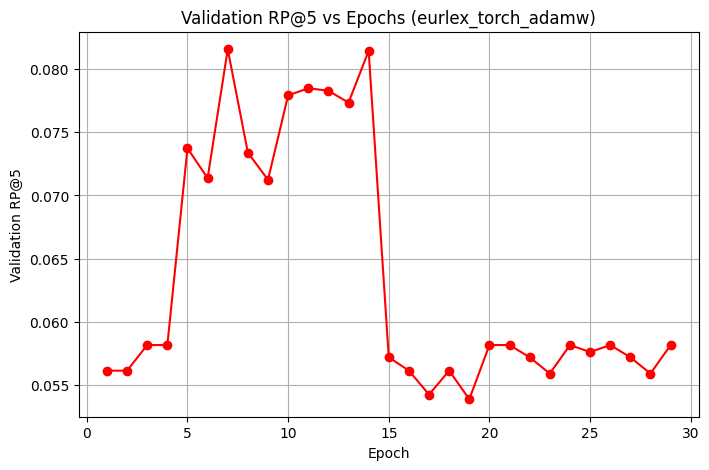

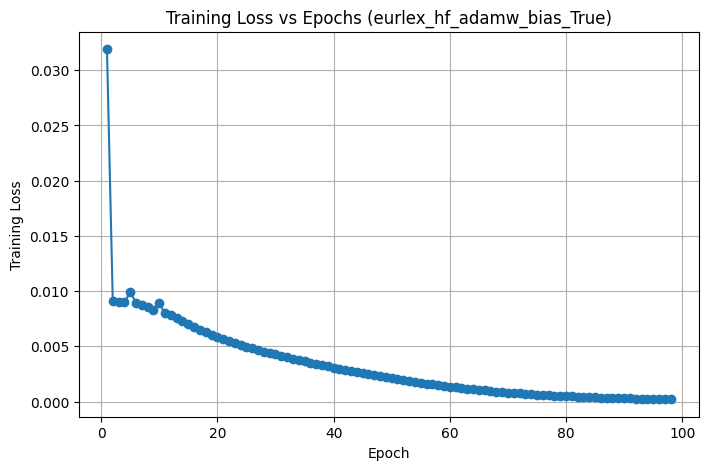

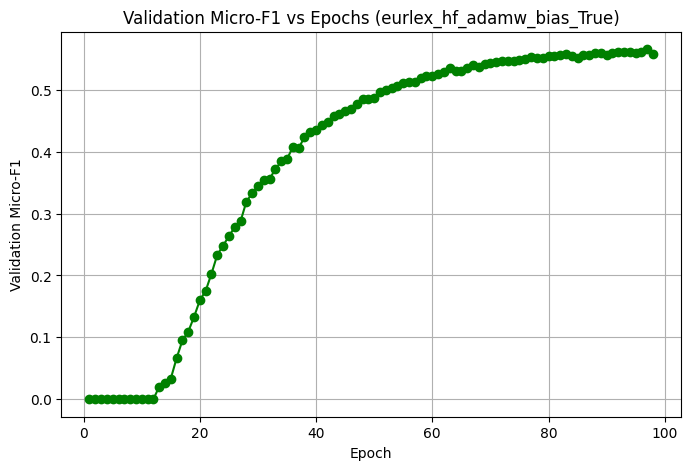

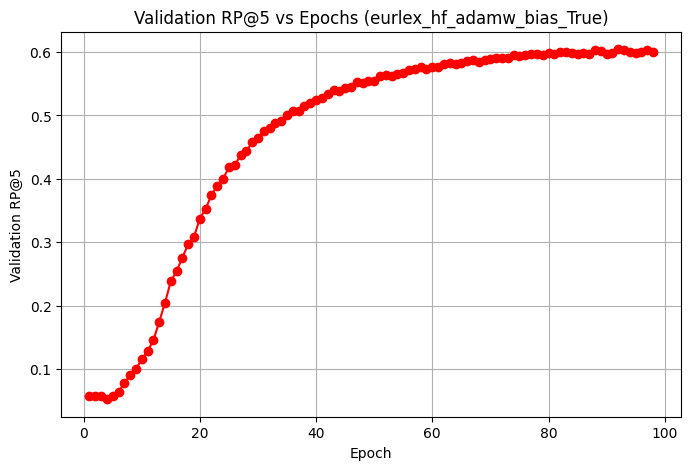

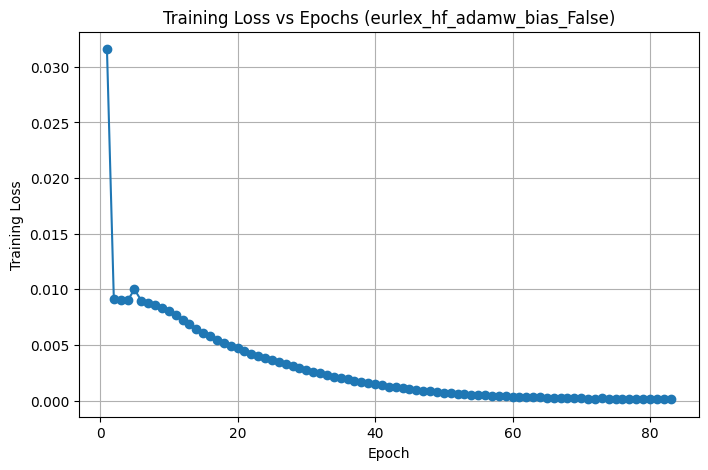

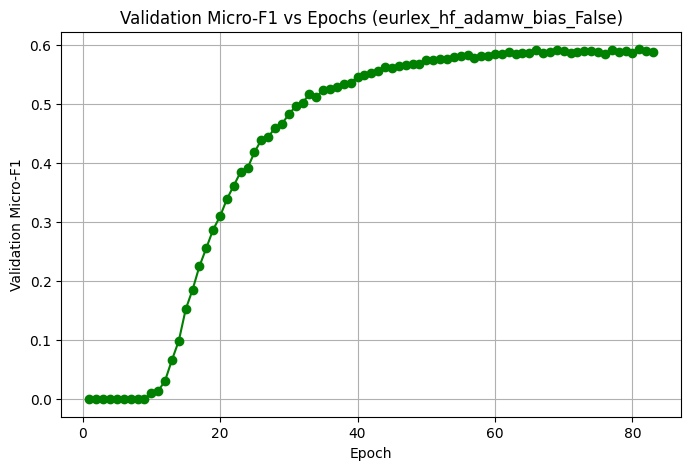

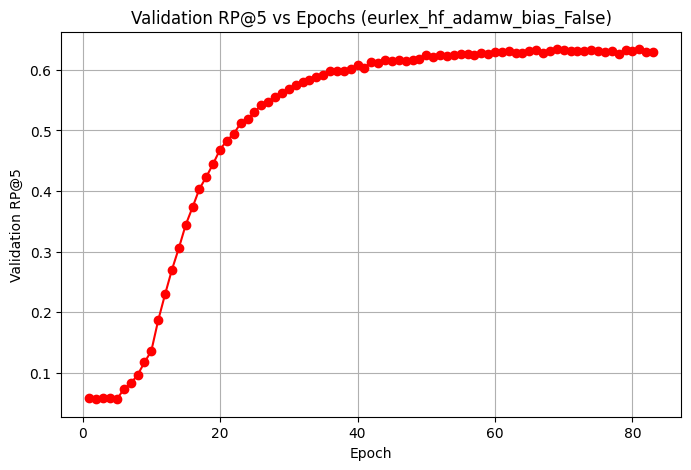

In [18]:
# %% [markdown]
# ## 5. Plot Results for Each Experiment Separately
# 
# For each experiment, we plot:
# - Training Loss vs Epochs
# - Validation Micro-F1 vs Epochs
# - Validation RP@5 vs Epochs

# %%
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment(exp_name, result):
    # Determine epoch numbers based on the number of recorded epochs.
    epochs_train = np.arange(1, len(result["train_losses"]) + 1)
    epochs_val = np.arange(1, len(result["val_metrics"]) + 1)
    
    # Plot Training Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_train, result["train_losses"], marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title(f"Training Loss vs Epochs ({exp_name})")
    plt.grid(True)
    plt.show()
    
    # Plot Validation Micro-F1
    micro_f1 = [m.get("Micro-F1", None) for m in result["val_metrics"]]
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_val, micro_f1, marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Micro-F1")
    plt.title(f"Validation Micro-F1 vs Epochs ({exp_name})")
    plt.grid(True)
    plt.show()
    
    # Plot Validation RP@5
    rp5 = [m.get("RP@5", None) for m in result["val_metrics"]]
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_val, rp5, marker='o', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Validation RP@5")
    plt.title(f"Validation RP@5 vs Epochs ({exp_name})")
    plt.grid(True)
    plt.show()

# Plot for each experiment separately.
plot_experiment("eurlex_torch_adamw", results_torch)
plot_experiment("eurlex_hf_adamw_bias_True", results_hf_true)
plot_experiment("eurlex_hf_adamw_bias_False", results_hf_false)


### Combined Plots for All Experiments

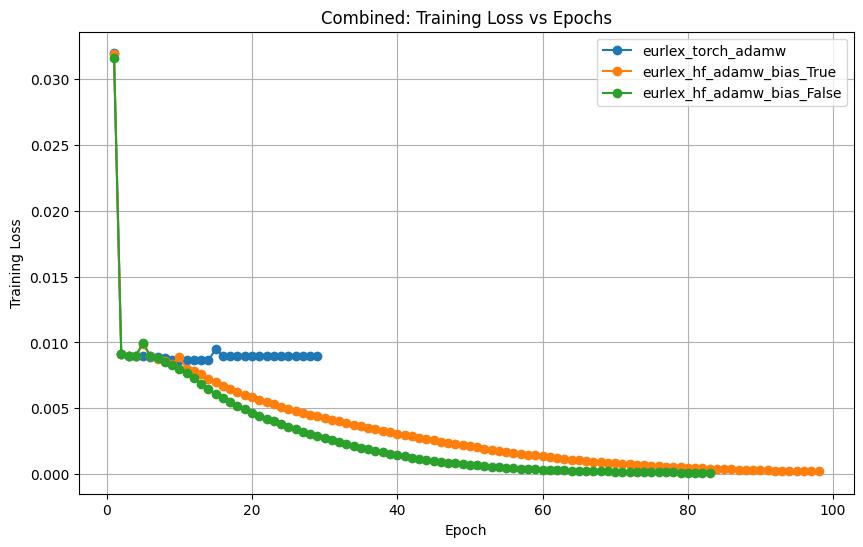

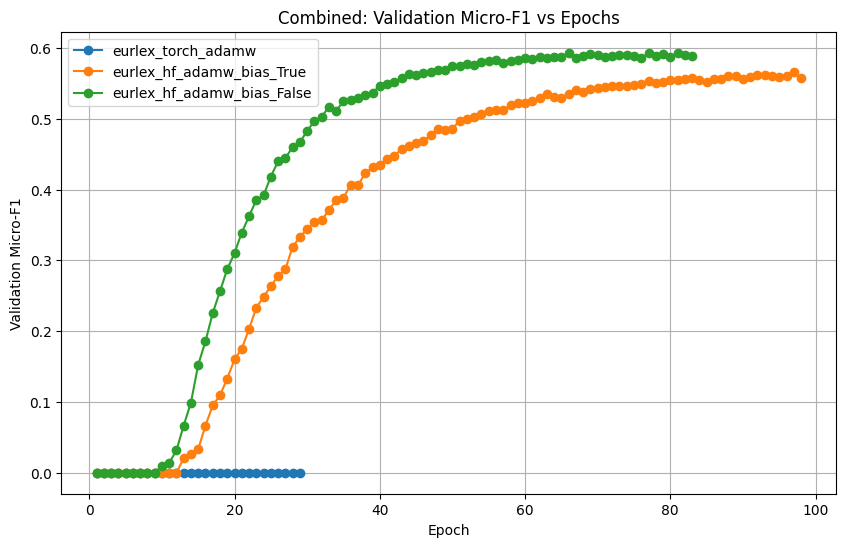

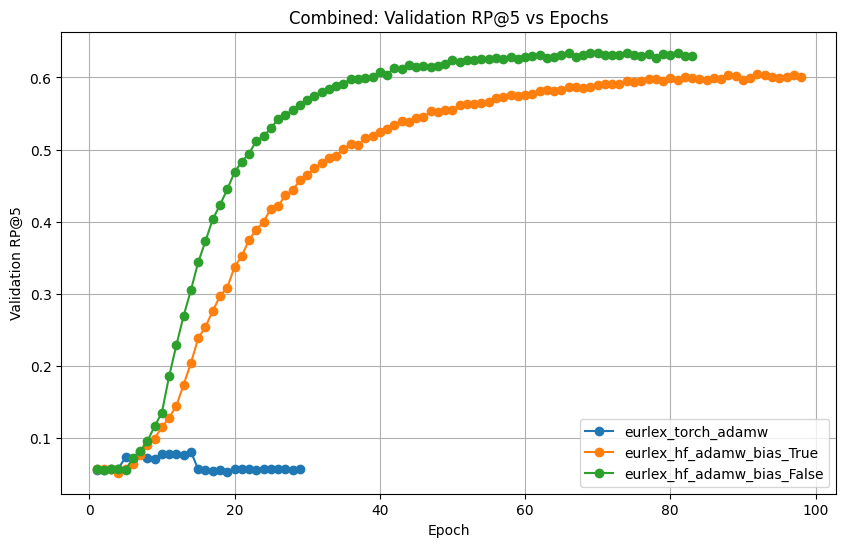

In [19]:
# %% [markdown]
# ## 6. Combined Plots for All Experiments
# 
# Here we generate combined plots for each metric (Training Loss, Validation Micro-F1, Validation RP@5)
# across all three experiments.

# %%
# Create a dictionary to hold the combined results.
combined_results = {
    "eurlex_torch_adamw": results_torch,
    "eurlex_hf_adamw_bias_True": results_hf_true,
    "eurlex_hf_adamw_bias_False": results_hf_false
}

# Combined plot for Training Loss
plt.figure(figsize=(10, 6))
for exp_name, res in combined_results.items():
    epochs = np.arange(1, len(res["train_losses"]) + 1)
    plt.plot(epochs, res["train_losses"], marker='o', label=exp_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Combined: Training Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Combined plot for Validation Micro-F1
plt.figure(figsize=(10, 6))
for exp_name, res in combined_results.items():
    epochs = np.arange(1, len(res["val_metrics"]) + 1)
    micro_f1 = [m.get("Micro-F1", None) for m in res["val_metrics"]]
    plt.plot(epochs, micro_f1, marker='o', label=exp_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Micro-F1")
plt.title("Combined: Validation Micro-F1 vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Combined plot for Validation RP@5
plt.figure(figsize=(10, 6))
for exp_name, res in combined_results.items():
    epochs = np.arange(1, len(res["val_metrics"]) + 1)
    rp5 = [m.get("RP@5", None) for m in res["val_metrics"]]
    plt.plot(epochs, rp5, marker='o', label=exp_name)
plt.xlabel("Epoch")
plt.ylabel("Validation RP@5")
plt.title("Combined: Validation RP@5 vs Epochs")
plt.legend()
plt.grid(True)
plt.show()
